# HW1: Audio effect classification

Implementation of a SVM classifier system able to predict the audio effect used in recordings of electric
guitar and bass. The classes that will be classified are: distortion, tremolo and no effect.

## 1) Importing all the libraries needed

In [1]:
import numpy as np
import librosa
import os
import matplotlib.pyplot as plt
import sklearn.svm
import IPython.display as ipd
import scipy as sp

For our problem we are going to use one low-level descriptor: the Root Mean Square (RMS) for both tremolo detection and distorsion detection. 

The Root Mean Square is defined as the square root of the mean energy of the signal.

## 2) Low-level features computation

In [2]:
# The Root Mean Square is one of the functions for spectral feature extraction already implemented in Librosa. 
# The function is librosa.feature.rms

# This function takes in input: the audio samples array obtained with the function librosa.load, the length of analysis frame 
# (in samples) for energy calculation and the hop length for STFT. 
# The output of the function is an array containing all the RMS values, one for each frame.

## 3) Compute training features

In [27]:
classes = ['Distortion', 'Tremolo', 'NoFX']
n_rms = 173

dict_train_features = {'Distortion': [], 'Tremolo': [], 'NoFX': []} #to store our feature we use a dictionary, which is a set 
# of couples of keys and values; the keys are Distortion, Tremolo, NoFX and the values are lists which will contain for each 
# audio file of the related folder the n_rms computed values of RMS.

for c in classes:
    # for each class the corresponding folder is:
    train_root = 'inputs/{}/training/'.format(c)  
    # now we retrieve all the files that are contained in this folder
    class_train_files = [f for f in os.listdir(train_root) if f.endswith('.wav')] # so we are creating a list of all the files 
    # contained in train_root and we are scanning all the files that are inside this list, checking that the format of
    # the file ends with '.wav'
    n_train_samples = len(class_train_files) # number of samples that we have
    
    # we initialize an empty matrix 
    train_features = np.zeros((n_train_samples, n_rms))
    
    # we start scanning all the files that are in the list of all our files
    for index, f in enumerate(class_train_files):
        audio, fs = librosa.load(os.path.join(train_root, f), sr=None) # here we are simply loading the files
        audio = audio/np.max(np.absolute(audio)) # normalizing the audio array
        rms_values = librosa.feature.rms(audio, frame_length=1024, hop_length=512)
        train_features[index] = rms_values
        
    dict_train_features[c] = train_features # we store the values using our dictionary; for each key (class) we have a set of
    # 173 RMS values for each file that is present in the corresponding class

## 4) Compute test features

In [30]:
dict_test_features = {'Distortion': [], 'Tremolo': [], 'NoFX': []}

for c in classes:
    test_root = 'inputs/{}/test/'.format(c)
    class_test_files = [f for f in os.listdir(test_root) if f.endswith('.wav')]
    n_test_samples = len(class_test_files)
    
    test_features = np.zeros((n_test_samples,  n_rms))
    
    for index, f in enumerate(class_test_files):
        audio, fs = librosa.load(os.path.join(test_root, f), sr=None)
        audio = audio/np.max(np.absolute(audio)) 
        rms_values = librosa.feature.rms(audio, frame_length=1024, hop_length=512)
        train_features[index] = rms_values
        
    dict_test_features[c] = test_features

In [29]:
dict_test_features

{'Distortion': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'Tremolo': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'NoFX': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])}

## 5) Plot of the Root Mean Square for the three classes

### Distortion

* TRAINING SET

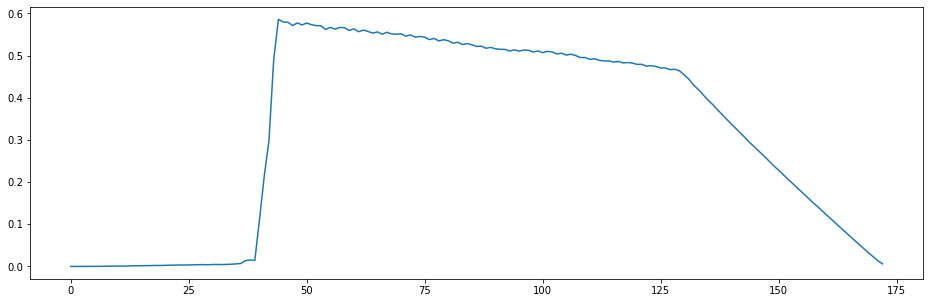

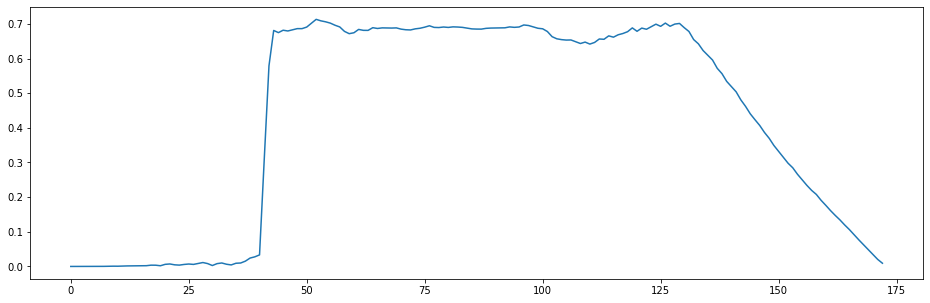

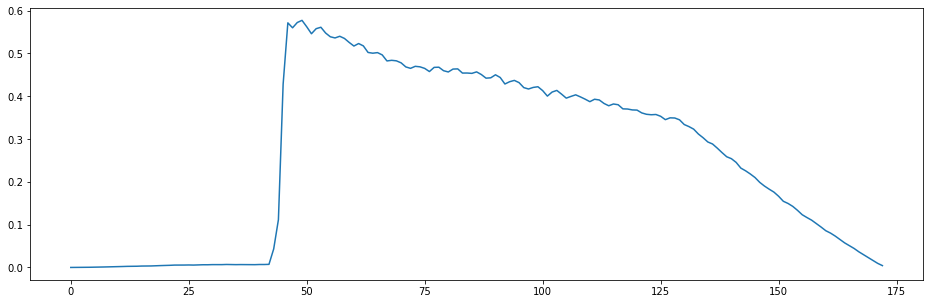

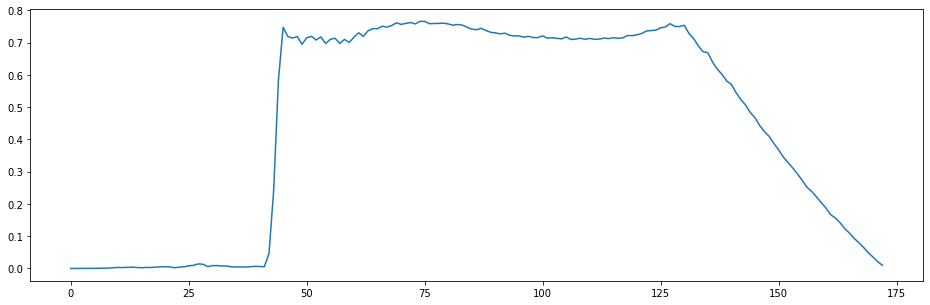

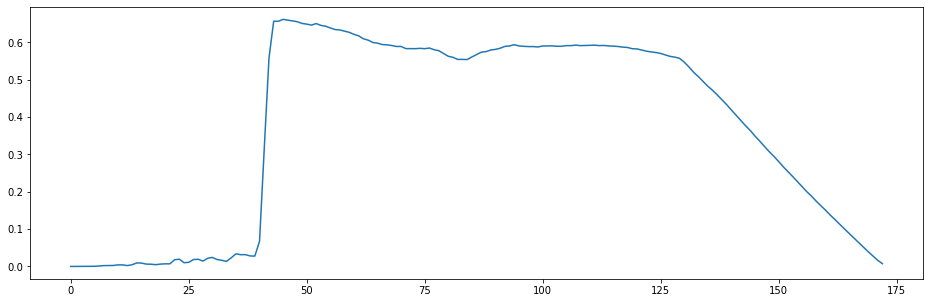

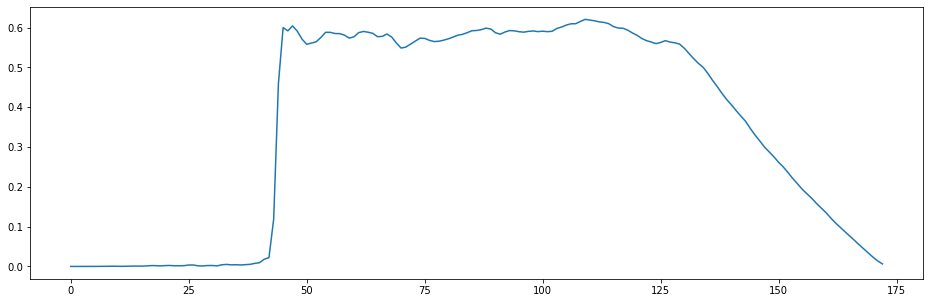

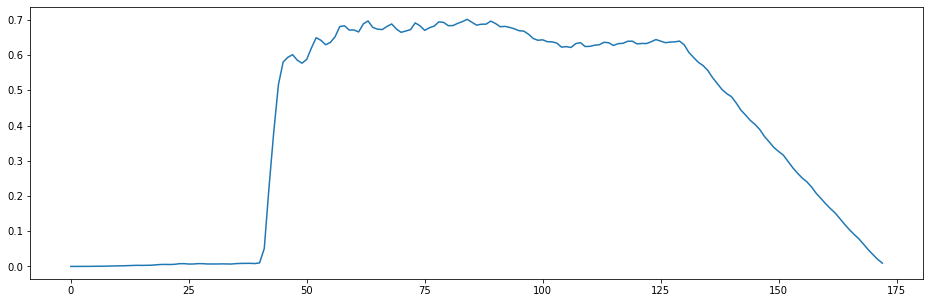

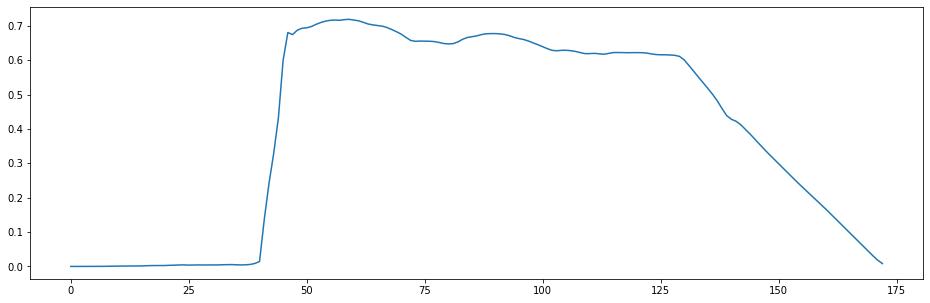

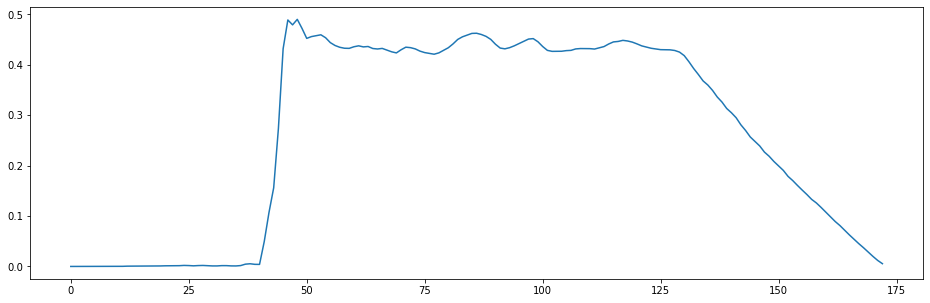

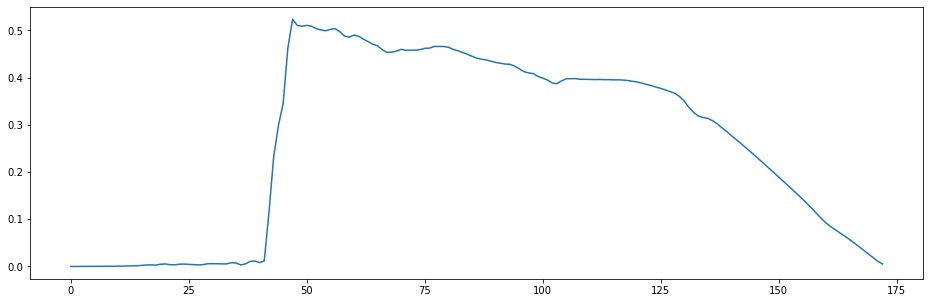

In [5]:
for rms in dict_train_features["Distortion"]:
    fig = plt.figure(figsize=(16, 5))
    plt.plot(np.arange(n_rms), np.transpose(rms))

- TEST SET

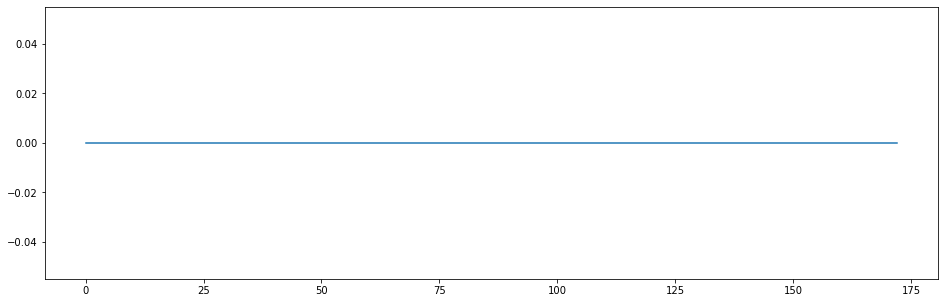

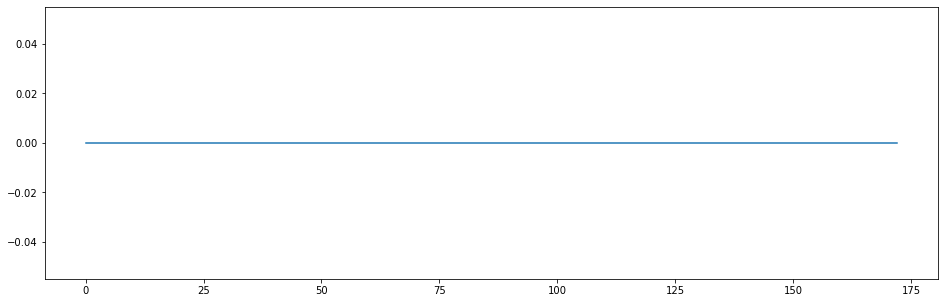

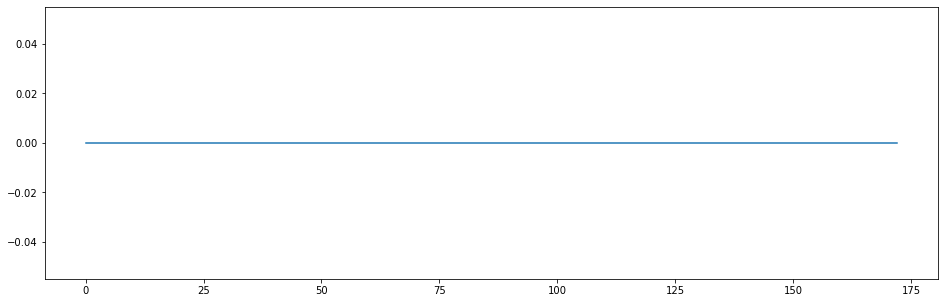

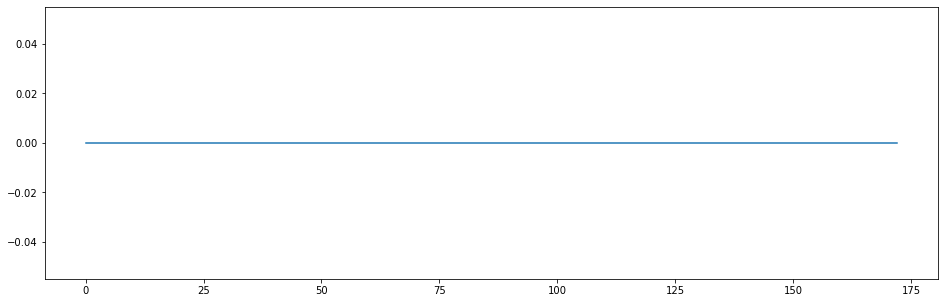

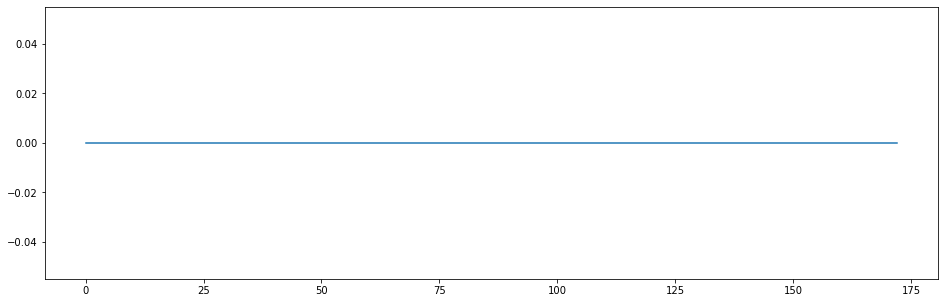

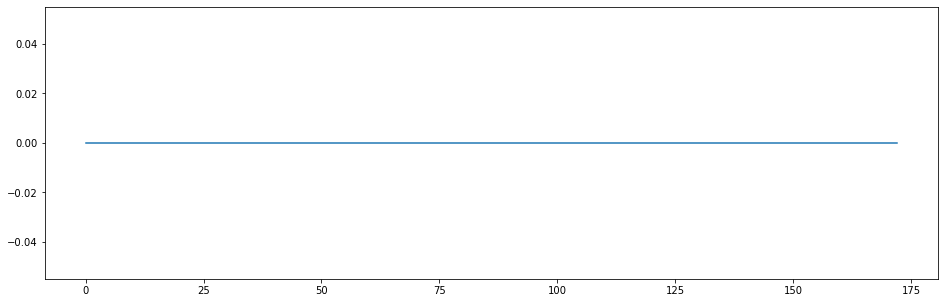

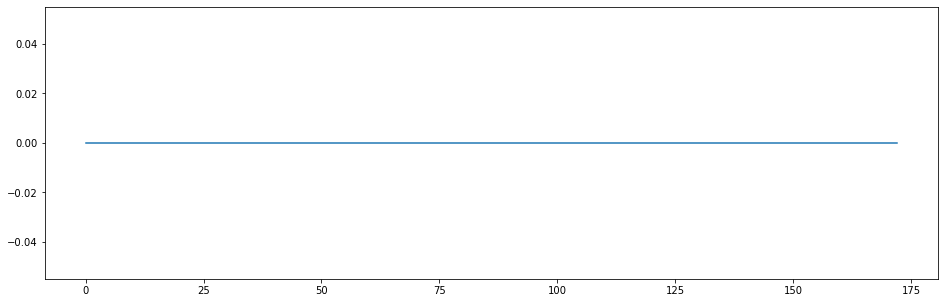

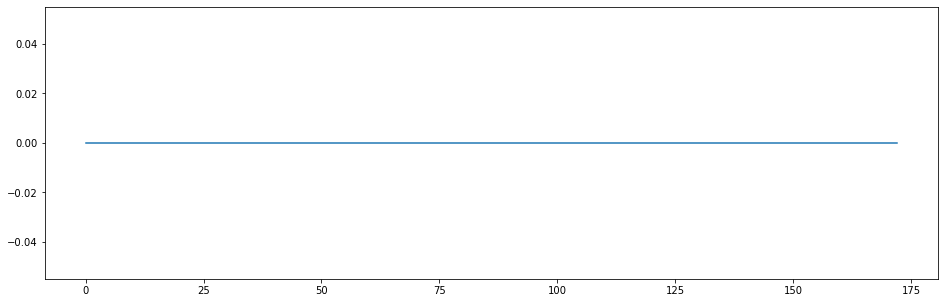

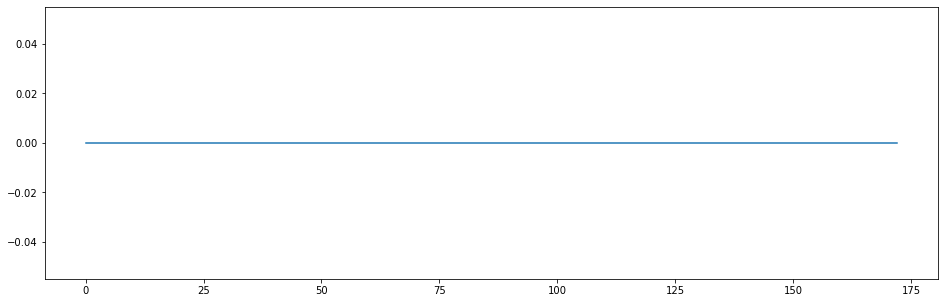

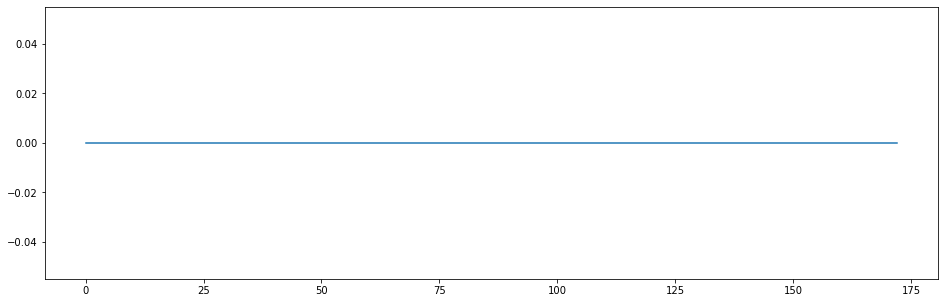

In [6]:
for rms in dict_test_features["Distortion"]:
    fig = plt.figure(figsize=(16, 5))
    plt.plot(np.arange(n_rms), np.transpose(rms))

### Tremolo

- TRAINING SET

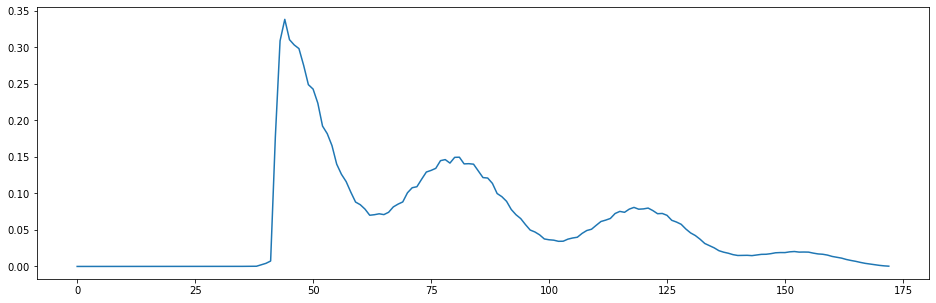

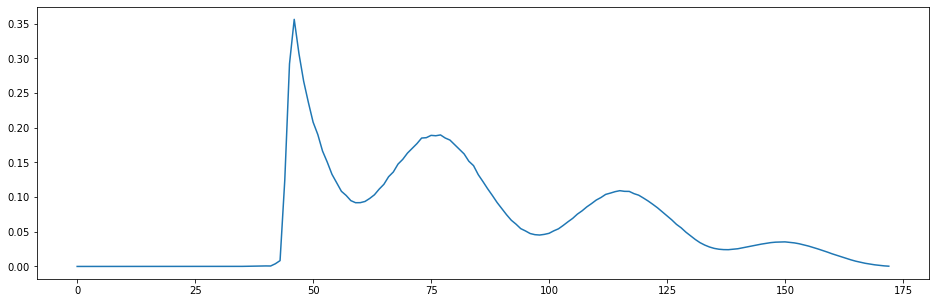

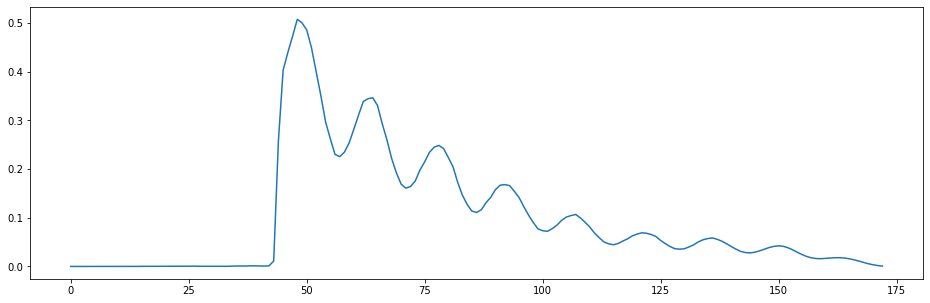

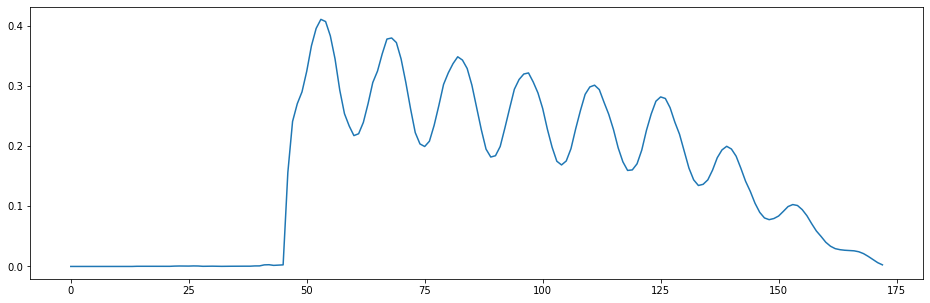

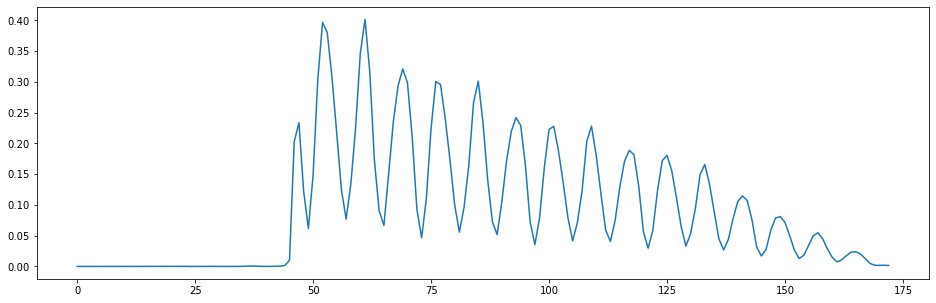

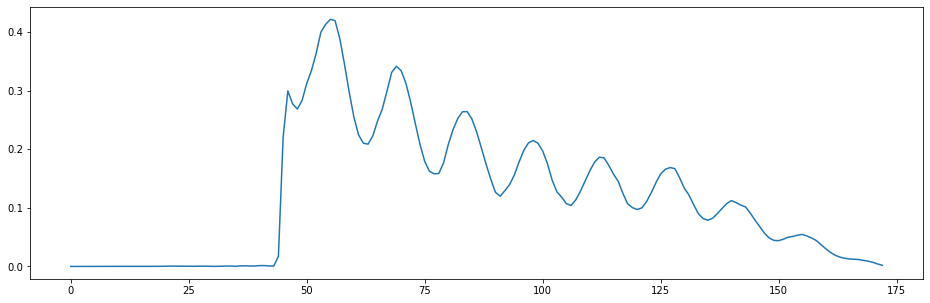

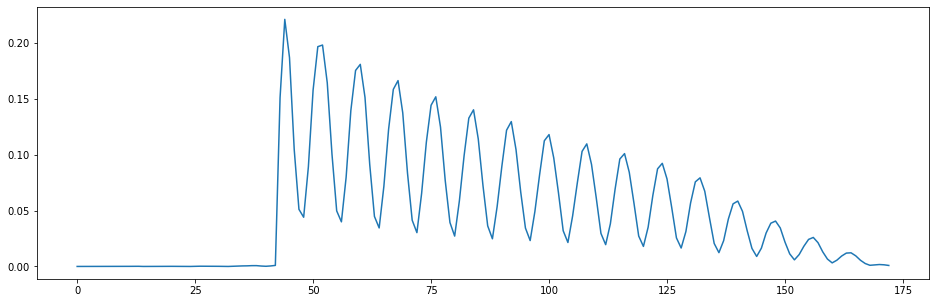

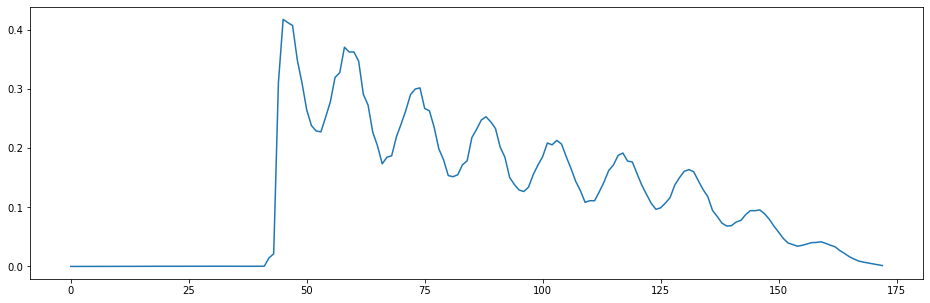

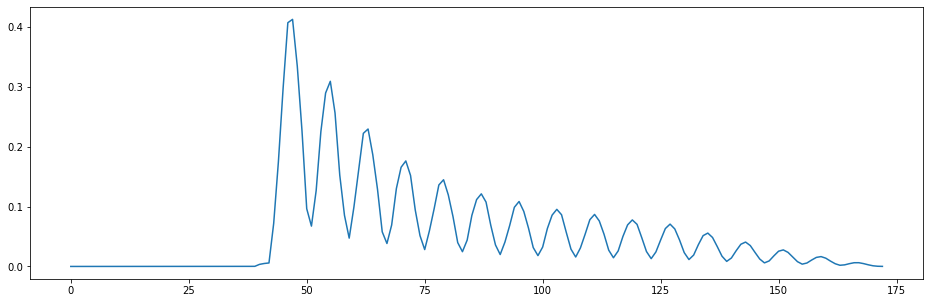

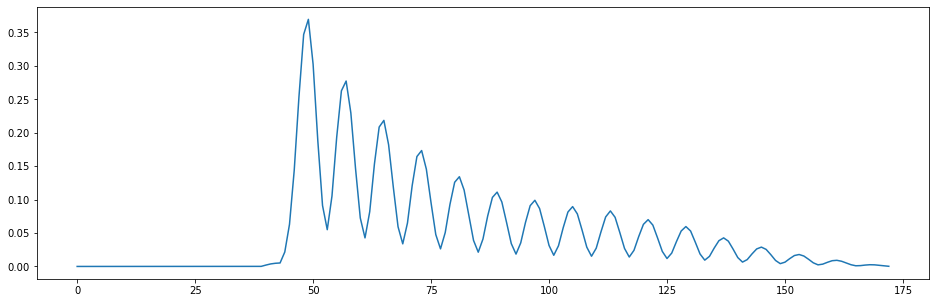

In [7]:
for rms in dict_train_features["Tremolo"]:
    fig = plt.figure(figsize=(16, 5))
    plt.plot(np.arange(n_rms), np.transpose(rms))

- TEST SET

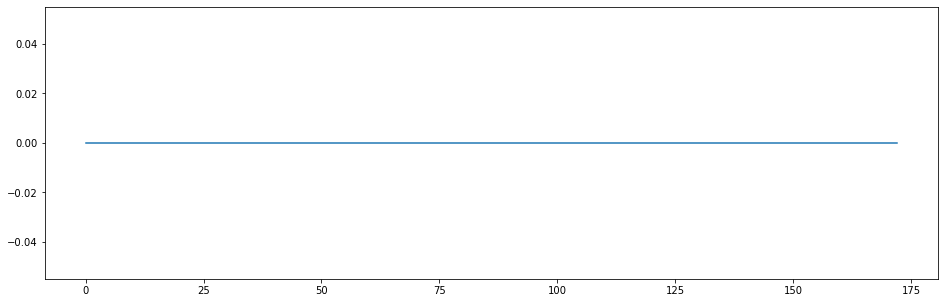

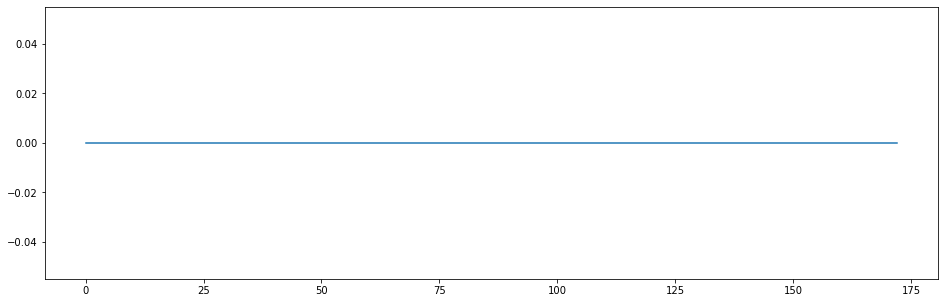

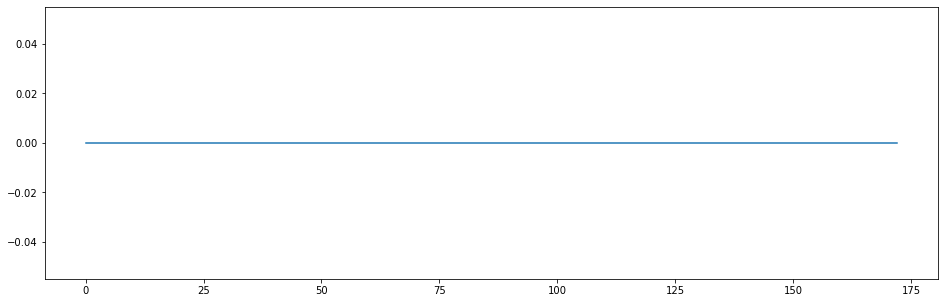

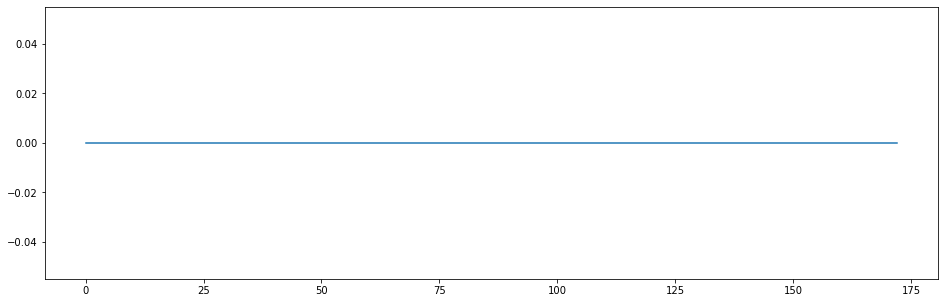

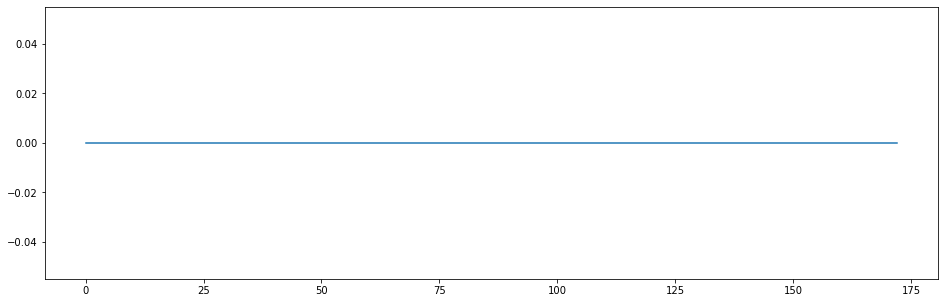

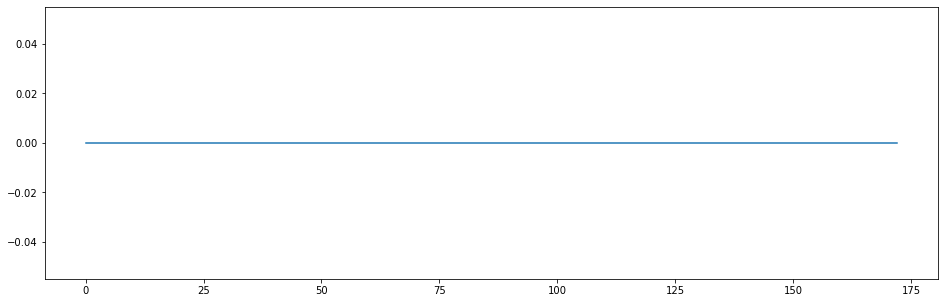

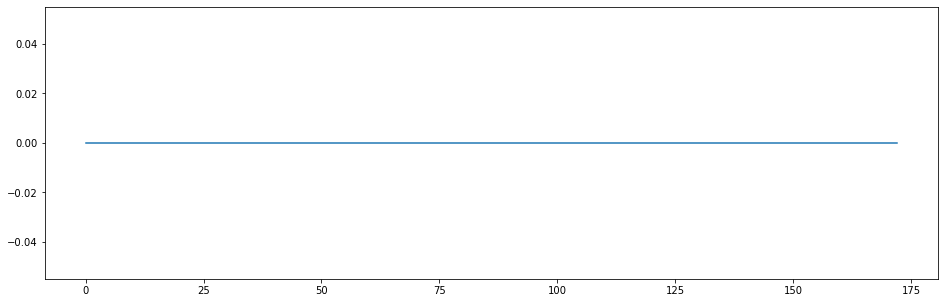

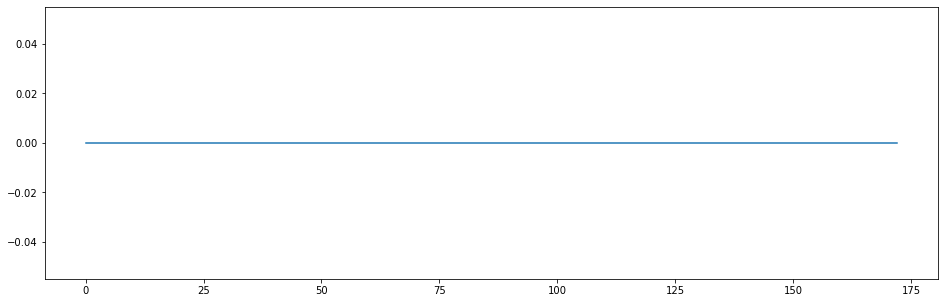

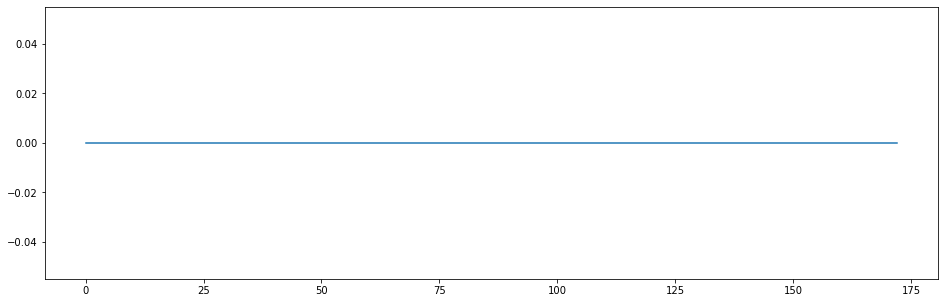

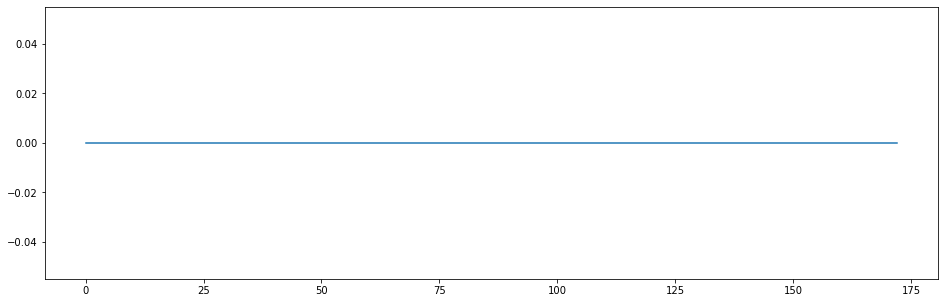

In [8]:
for rms in dict_test_features["Tremolo"]:
    fig = plt.figure(figsize=(16, 5))
    plt.plot(np.arange(n_rms), np.transpose(rms))

### No effect

- TRAINING SET

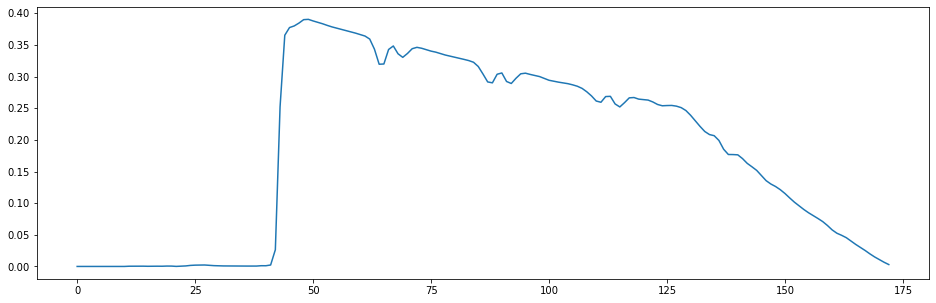

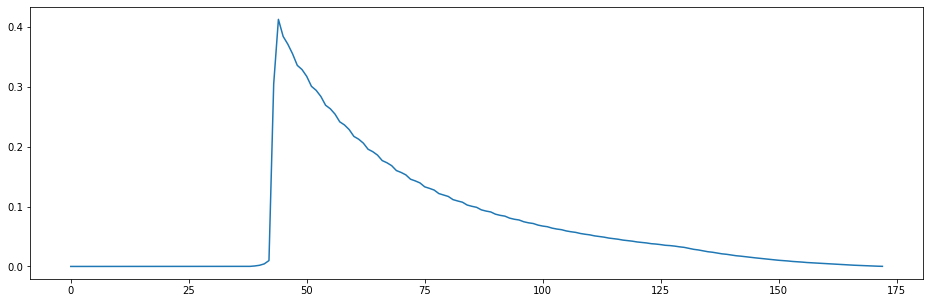

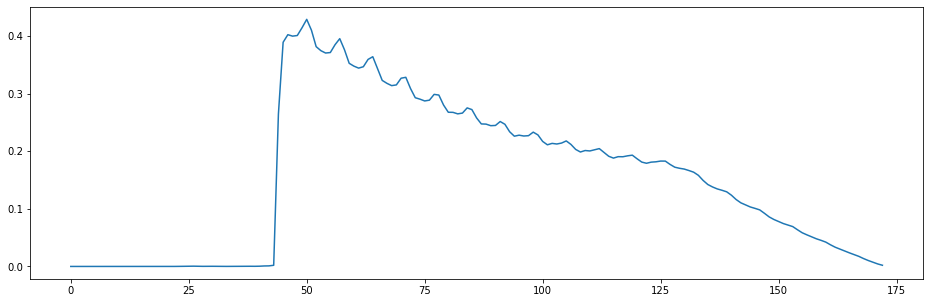

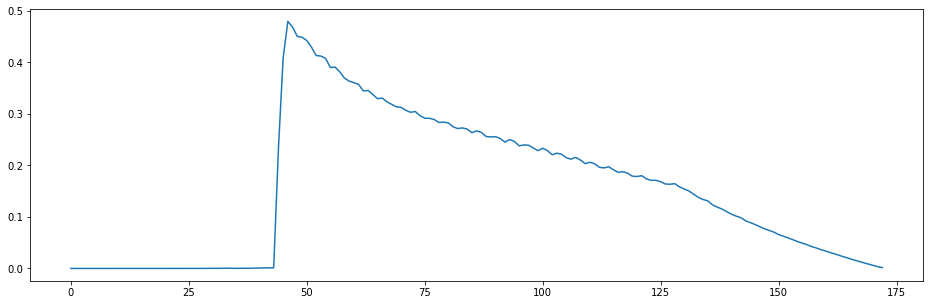

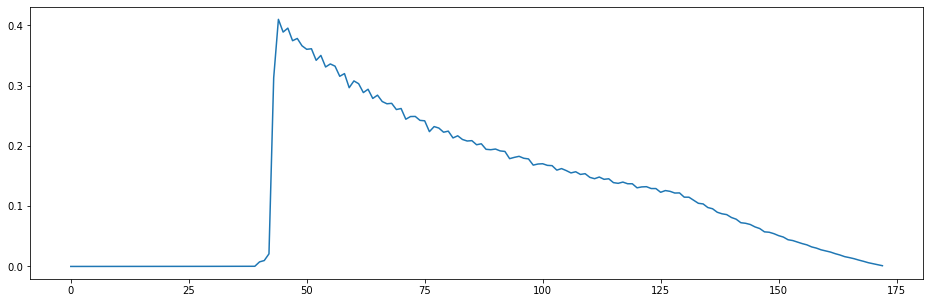

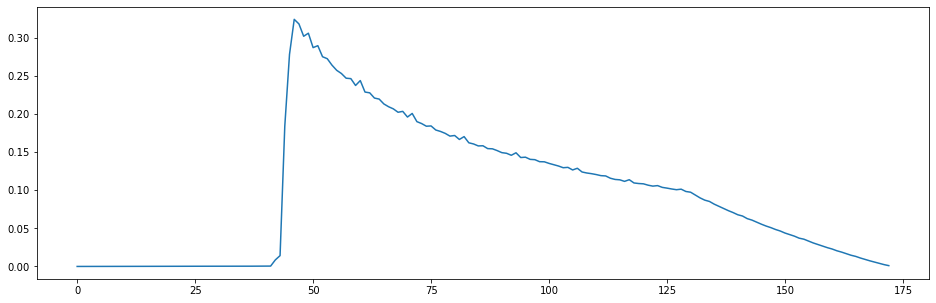

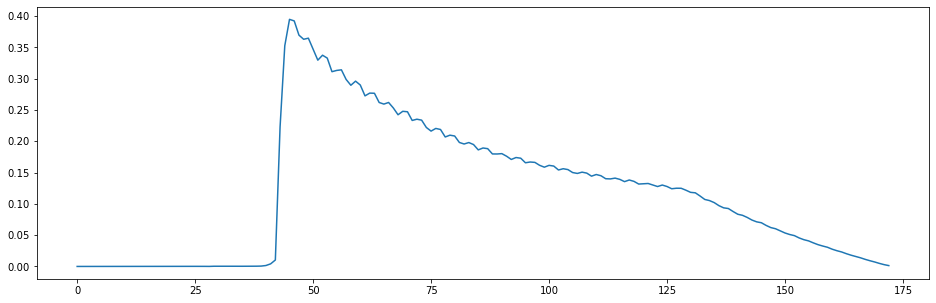

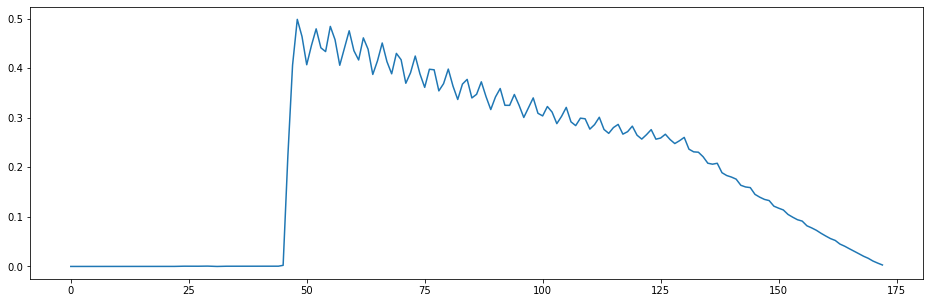

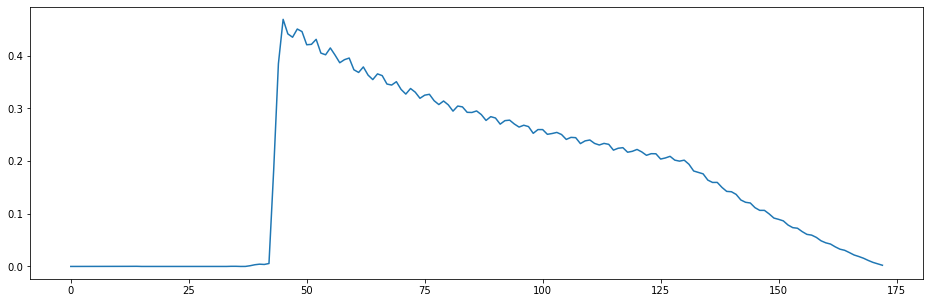

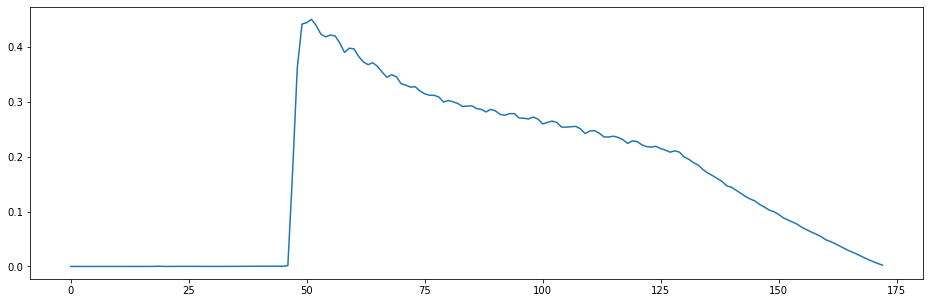

In [9]:
for rms in dict_train_features["NoFX"]:
    fig = plt.figure(figsize=(16, 5))
    plt.plot(np.arange(n_rms), np.transpose(rms))

- TEST SET

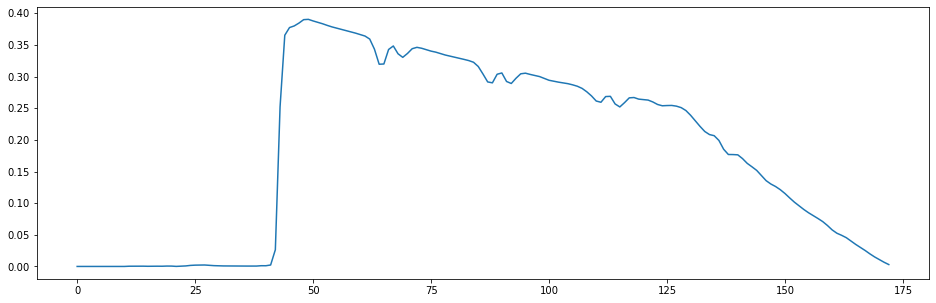

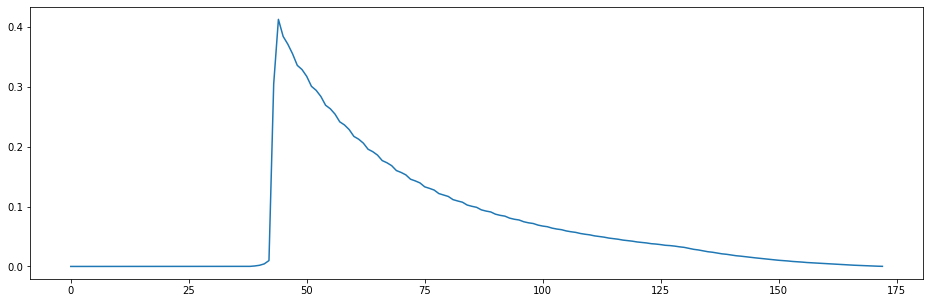

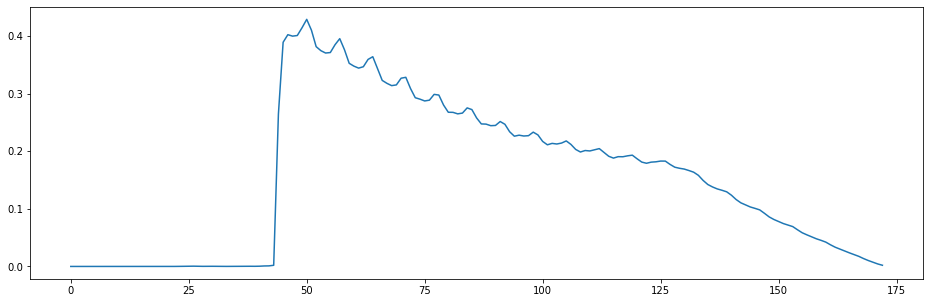

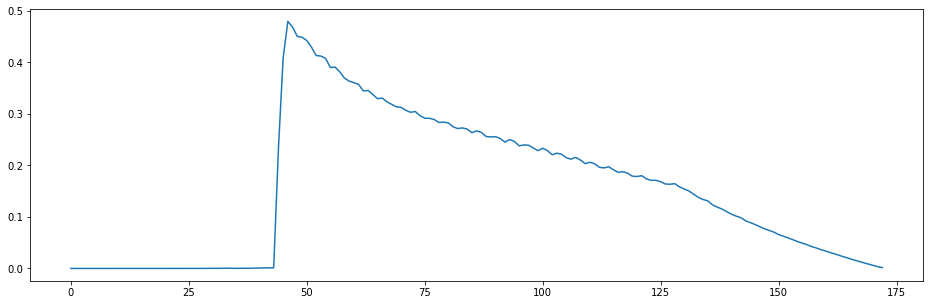

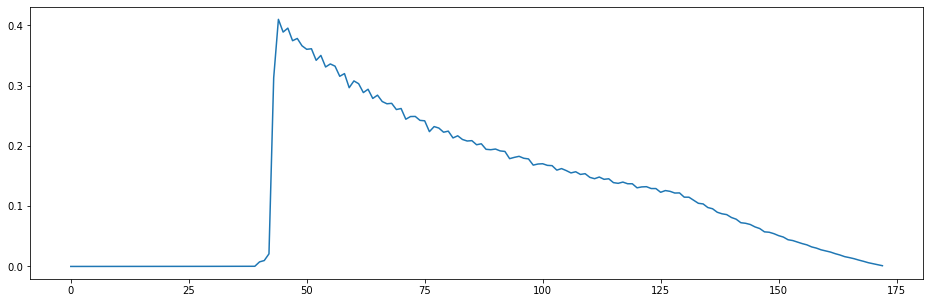

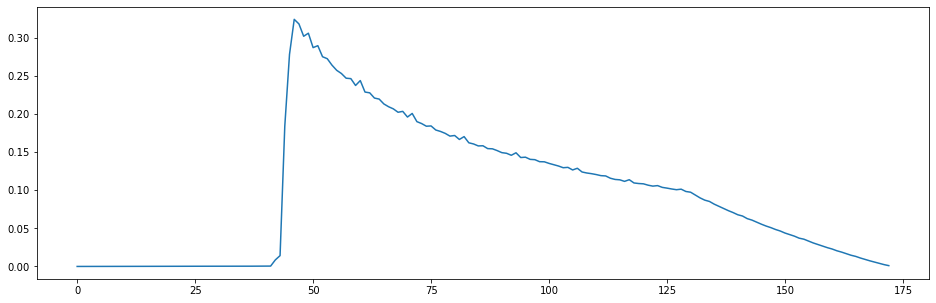

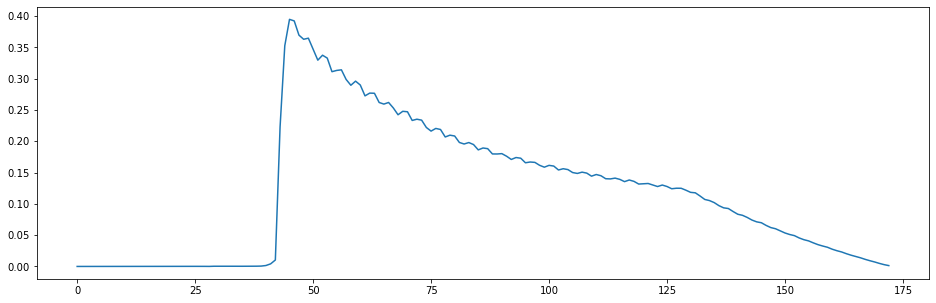

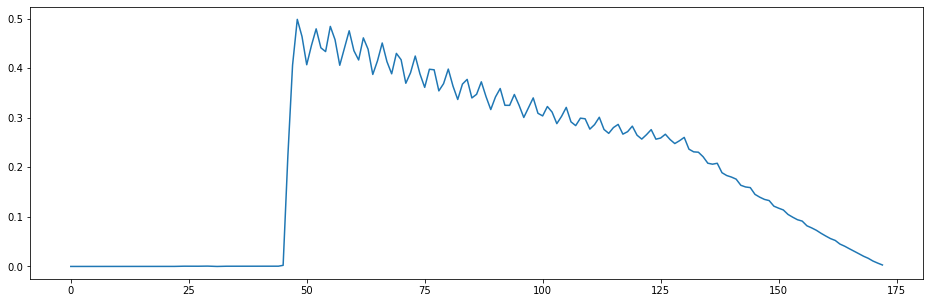

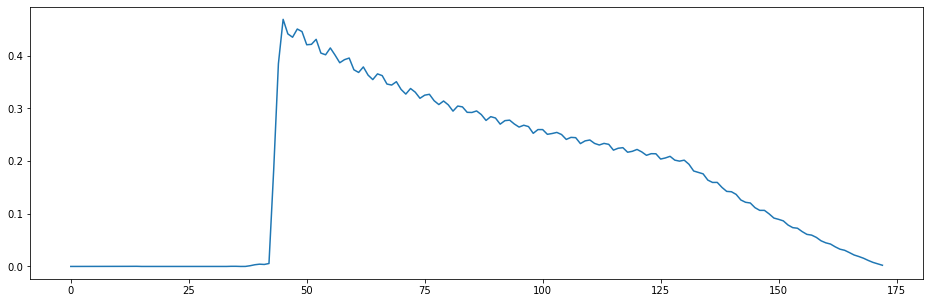

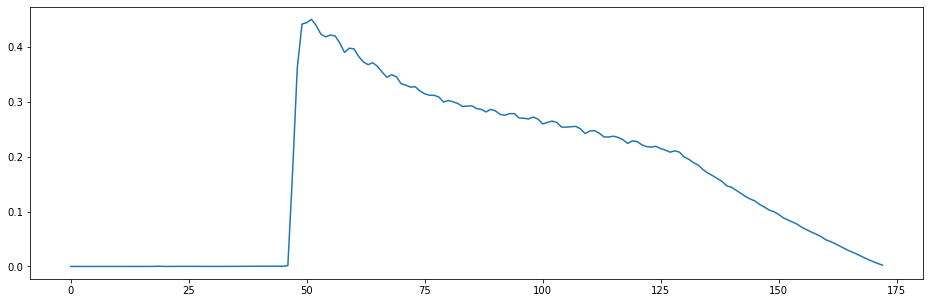

In [10]:
for rms in dict_train_features["NoFX"]:
    fig = plt.figure(figsize=(16, 5))
    plt.plot(np.arange(n_rms), np.transpose(rms))

## 6) Compute Weighted Support Vector Machine

Specifically, each example in the training dataset has its own penalty term (C value) used in the calculation for the margin when fitting the SVM model. The value of an example’s C-value can be calculated as a weighting of the global C-value, where the weight is defined proportional to the class distribution:

$C_i = weight_i * C$

A larger weighting can be used for the minority class, allowing the margin to be softer, whereas a smaller weighting can be used for the majority class, forcing the margin to be harder and preventing misclassified examples.

Small Weight: Smaller C value, larger penalty for misclassified examples.

Larger Weight: Larger C value, smaller penalty for misclassified examples.

This has the effect of encouraging the margin to contain the majority class with less flexibility, but allow the minority class to be flexible with misclassification of majority class examples onto the minority class side if needed.

In [11]:
class_0 = 'Distortion'
class_1 = 'Tremolo'
class_2 = 'NoFX'

# from the train dictionary we extract the 3 features:
X_train_0 = dict_train_features[class_0]
X_train_1 = dict_train_features[class_1]
X_train_2 = dict_train_features[class_2]

y_train_0 = np.zeros((X_train_0.shape[0],))
y_train_1 = np.ones((X_train_1.shape[0],))
y_train_2 = np.ones((X_train_2.shape[0],))*2

In [12]:
# from the test dictionary we extract the 3 features:
X_test_0 = dict_test_features[class_0]
X_test_1 = dict_test_features[class_1]
X_test_2 = dict_test_features[class_2]


y_test_0 = np.zeros((X_test_0.shape[0],))
y_test_1 = np.ones((X_test_1.shape[0],))
y_test_2 = np.ones((X_test_2.shape[0],))*2

# we build a label array
y_test_mc = np.concatenate((y_test_0, y_test_1, y_test_2), axis=0)

### Normalize the features

In [13]:
# normalization parameters (feat_max, feat_min) should be computed on train only and then used on both train and test set, 
# because in principle we don't have any information about the test part of the dataset

# we extract the max and the min of the 3 trains
feat_max = np.max(np.concatenate((X_train_0, X_train_1, X_train_2), axis=0), axis=0)
feat_min = np.min(np.concatenate((X_train_0, X_train_1, X_train_2), axis=0), axis=0)

# we apply the normalization to X_train_0, X_train_1 and X_train_2 
X_train_0_normalized = (X_train_0 - feat_min) / (feat_max - feat_min)
X_train_1_normalized = (X_train_1 - feat_min) / (feat_max - feat_min)
X_train_2_normalized = (X_train_2 - feat_min) / (feat_max - feat_min)

# we apply the normalization to X_test_0, X_test_1 and X_test_2 
X_test_0_normalized = (X_test_0 - feat_min) / (feat_max - feat_min)
X_test_1_normalized = (X_test_1 - feat_min) / (feat_max - feat_min)
X_test_2_normalized = (X_test_2 - feat_min) / (feat_max - feat_min)

X_test_mc_normalized = np.concatenate((X_test_0_normalized, X_test_1_normalized, X_test_2_normalized), axis=0)

### Define and train a model for each couple of classes

In [14]:
SVM_parameters={
    'C': 100, 
    # C stands for the regularization parameter that controls the trade-off between maximizing the separation margin 
    # between classes and minimizing the number of misclassified instances.
    # C determines the number and severity of the violations to the margin (and to the hyperplane) that we will tolerate.
    'kernel': 'rbf',
    #'class_weight' : 'balanced'
    #b By default, each class has the same weighting, which means that the softness of the margin is symmetrical.
}

# definition of the 3 classifiers
clf_01 = sklearn.svm.SVC(**SVM_parameters, probability=True) #trained to understand the difference between class 0 and class 1
clf_02 = sklearn.svm.SVC(**SVM_parameters, probability=True) #trained to understand the difference between class 0 and class 2
clf_12 = sklearn.svm.SVC(**SVM_parameters, probability=True) #trained to understand the difference between class 1 and class 2

### Fit the classifiers with the correct data

In [15]:
clf_01.fit(np.concatenate((X_train_0_normalized, X_train_1_normalized), axis=0), 
           np.concatenate((y_train_0, y_train_1), axis=0))
           
clf_02.fit(np.concatenate((X_train_0_normalized, X_train_2_normalized), axis=0), 
           np.concatenate((y_train_0, y_train_2), axis=0))

clf_12.fit(np.concatenate((X_train_1_normalized, X_train_2_normalized), axis=0), 
           np.concatenate((y_train_1, y_train_2), axis=0))

SVC(C=100, probability=True)

### Evaluate each classifier

In [16]:
# we now predict the label on the test; these classifiers are all binary classifiers
y_test_predicted_01 = clf_01.predict(X_test_mc_normalized).reshape(-1, 1)
y_test_predicted_02 = clf_02.predict(X_test_mc_normalized).reshape(-1, 1)
y_test_predicted_12 = clf_12.predict(X_test_mc_normalized).reshape(-1, 1)

### Apply a majority voting strategy

In [17]:
y_test_predicted_mc = np.concatenate((y_test_predicted_01, y_test_predicted_02, y_test_predicted_12), axis=1)
y_test_predicted_mc = np.array(y_test_predicted_mc, dtype=np.int)

In [18]:
y_test_predicted_mv = np.zeros((y_test_predicted_mc.shape[0],))
for i, e in enumerate(y_test_predicted_mc):
    y_test_predicted_mv[i] = np.bincount(e).argmax() 

 ## 7) Compute the confusion matrix

In [19]:
def compute_cm_multiclass(gt, predicted):
    classes = np.unique(gt)
    
    CM = np.zeros((len(classes), len(classes)))
    
    for i in np.arange(len(classes)):
        pred_class = predicted[gt==i]
        
        for j in np.arange(len(pred_class)):
            CM[i, int(pred_class[j])] = CM[i, int(pred_class[j])] + 1 
    print(CM)

In [20]:
compute_cm_multiclass(y_test_mc, y_test_predicted_mv)

[[ 0. 10.  0.]
 [ 0. 10.  0.]
 [ 0. 10.  0.]]
